# Mask R-CNN - Train on Shapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
sys.path.append('../')

from mrcnn.config import Config
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mrcnn.shapes as shapes
from mrcnn.dataset import Dataset 

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")

# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")
import tensorflow as tf
import keras
import pprint
import keras.backend as KB

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)

config = shapes.ShapesConfig()
config.BATCH_SIZE      = 2                    #Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 2
config.STEPS_PER_EPOCH = 7
# config.IMAGES_PER_GPU  = 1

config.display() 


D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.4.0   Keras Version : 2.1.3 

Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE  

## Configurations

In [ ]:
# from keras import backend as KB
# if 'tensorflow' == KB.backend():
#     import tensorflow as tf
#     from keras.backend.tensorflow_backend import set_session
#     # tfconfig = tf.ConfigProto(
#         # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5),
#         # device_count = {'GPU': 1}
#     # )    
#     tfconfig = tf.ConfigProto()
#     tfconfig.gpu_options.allow_growth=True
#     tfconfig.gpu_options.visible_device_list = "0"
#     tfconfig.gpu_options.per_process_gpu_memory_fraction=0.5
#     tf_sess = tf.Session(config=tfconfig)
#     set_session(tf_sess)

## Notebook Preferences

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [2]:
# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [7]:
# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [196]:
# import importlib
# importlib.reload(model)
# Create model in training mode
# MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
import  gc
# del history
try :
    del model
except: 
    pass
 
gc.collect()

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180319T1552\mask_rcnn_shapes_{epoch:04d}.h5
 IMAGE SHAPE is : 128    128
<class 'list'>
Tensor("rpn_class_logits_1/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class_logits_1/concat:0
Tensor("rpn_class_1/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class_1/concat:0
Tensor("rpn_bbox_1/concat:0", shape=(?, ?, 4), dtype=float32) rpn_bbox_1/concat:0
Proposal Layer init complete. Size of anchors:  (4092, 4)
Tensor("proposal_targets_1/Shape_2:0", shape=(2,), dtype=int32)
Tensor("proposal_targets_1/Shape_4:0", shape=(2,), dtype=int32)
Shape of overlaps Tensor("proposal_targets_1/Shape_7:0", shape=(2,), dtype=int32)
Tensor("proposal_targets_1/Shape_9:0", shape=(2,), dtype=int32)
Tensor("proposal_targets_1/Shape_11:0", shape=(2,), dtype=int32)
Shape of overlaps Tensor("proposal_targets_1/Shape_14:0", shape=(2,), dtype=int32)
Tensor("proposal_targets_1/Shape_21:0", shape=(2,), dtype=int32)
Tensor("proposal_targets_1/Shape_23:

In [197]:
print(MODEL_PATH)
print(COCO_MODEL_PATH)
print(RESNET_MODEL_PATH)
print(MODEL_DIR)
print(model.find_last())

E:\Models
E:\Models\mask_rcnn_coco.h5
E:\Models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
E:\Models\mrcnn_logs
find_last info:   dir_name: E:\Models\mrcnn_logs\shapes20180313T1856
find_last info: checkpoint: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0221.h5
('E:\\Models\\mrcnn_logs\\shapes20180313T1856', 'E:\\Models\\mrcnn_logs\\shapes20180313T1856\\mask_rcnn_shapes_0221.h5')


In [198]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
#     loc=model.load_weights(model.get_imagenet_weights(), by_name=True)
    loc=model.load_weights(RESNET_MODEL_PATH, by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)
print('Load weights complete')

find_last info:   dir_name: E:\Models\mrcnn_logs\shapes20180313T1856
find_last info: checkpoint: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0221.h5
load_weights:      from: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0221.h5
set_log_dir:  model_path (input) is : E:/Models/mrcnn_logs/shapes20180313T1856/mask_rcnn_shapes_0221.h5  
self.epoch set to 222  (Next epoch to run)
set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_{epoch:04d}.h5
Load weights complete


In [ ]:
# for i in range(len(model.keras_model.layers)):
#     print(i, ' Name of layer: ', model.keras_model.layers[i].name)

In [ ]:
# sess = tf.InteractiveSession()
# model.keras_model.layers[229].output.eval()

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

### Training head using  Keras.model.fit_generator()

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=69, 
            layers='heads')

### Training heads using train_on_batch()

We need to use this method for the time being as the fit generator does not have provide EASY access to the output in Keras call backs. By training in batches, we pass a batch through the network, pick up the generated RoI detections and bounding boxes and generate our semantic / gaussian tensors ...



In [200]:

model.train_in_batches(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run = 1,
            layers='heads')

Last epoch completed : 223 
Starting from epoch 223 for 1 epochs. LR=0.001
Steps per epoch:   7 
Checkpoint Folder: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_{epoch:04d}.h5
Checkpoint folder already exists

Selecting layers to train
Layer    Layer Name               Layer Type
174  fpn_c5p5               (Conv2D)
176  fpn_c4p4               (Conv2D)
179  fpn_c3p3               (Conv2D)
182  fpn_c2p2               (Conv2D)
184  fpn_p5                 (Conv2D)
185  fpn_p2                 (Conv2D)
186  fpn_p3                 (Conv2D)
187  fpn_p4                 (Conv2D)
In model:  rpn_model
      1  rpn_conv_shared        (Conv2D)
      2  rpn_class_raw          (Conv2D)
      4  rpn_bbox_pred          (Conv2D)
199  mrcnn_mask_conv1       (TimeDistributed)
200  mrcnn_mask_bn1         (TimeDistributed)
202  mrcnn_mask_conv2       (TimeDistributed)
204  mrcnn_mask_bn2         (TimeDistributed)
205  mrcnn_class_conv1      (TimeDistributed)
207  mrcnn_class_bn1        (TimeDis

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


7/7 [==============================] - 16s 2s/step - loss: 0.8989 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4266 - mrcnn_class_loss: 0.1288 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.2729

Epoch 00224: loss improved from inf to 0.69801, saving model to E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0224.h5
Final : self.epoch 224   epochs 224


#### Some network information 

In [201]:
# print(KB.eval(KB.learning_phase()))
KB.set_learning_phase(1)
print(' Learning phase values is L ' ,KB.learning_phase())
mm = model.keras_model
print('\n Outputs: ') 
pp.pprint(mm.outputs)
# pp.pprint(mm.fit_generator.__dict__['__wrapped__'])

print('\n Losses: ') 
pp.pprint(mm.losses)
print('\n Metric Names')
pp.pprint(mm.metrics_names)
print('\n Metrics: ') 
pp.pprint(mm._get_deduped_metrics_names())


 Learning phase values is L  1

 Outputs: 
[ <tf.Tensor 'output_rois_1/mul:0' shape=(2, ?, ?) dtype=float32>,
  <tf.Tensor 'rpn_class_logits_1/concat:0' shape=(?, ?, 2) dtype=float32>,
  <tf.Tensor 'proposal_rois_1/packed_2:0' shape=(2, ?, ?) dtype=float32>,
  <tf.Tensor 'rpn_class_1/concat:0' shape=(?, ?, 2) dtype=float32>,
  <tf.Tensor 'rpn_bbox_1/concat:0' shape=(?, ?, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_class_logits_1/Reshape_1:0' shape=(?, 32, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_class_1/Reshape_1:0' shape=(?, 32, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_bbox_1/Reshape:0' shape=(?, 32, 4, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_mask_1/Reshape_1:0' shape=(?, 32, 28, 28, 4) dtype=float32>,
  <tf.Tensor 'rpn_class_loss_1/cond/Merge:0' shape=() dtype=float32>,
  <tf.Tensor 'rpn_bbox_loss_1/cond/Merge:0' shape=() dtype=float32>,
  <tf.Tensor 'mrcnn_class_loss_1/truediv:0' shape=() dtype=float32>,
  <tf.Tensor 'mrcnn_bbox_loss_1/Reshape_3:0' shape=(1, 1) dtype=float32>,
  <tf.Tensor '

In [202]:
from mrcnn.datagen import data_generator, load_image_gt
np.set_printoptions(linewidth=100)
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

### Display shape loaded 

In [347]:
sample_x, sample_y = next(train_generator)

[220 123]


<IPython.core.display.Javascript object>


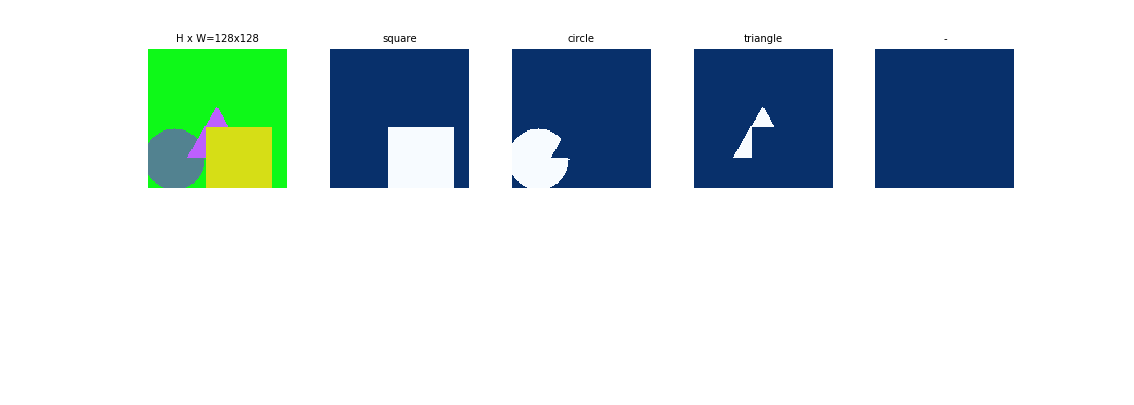

<IPython.core.display.Javascript object>


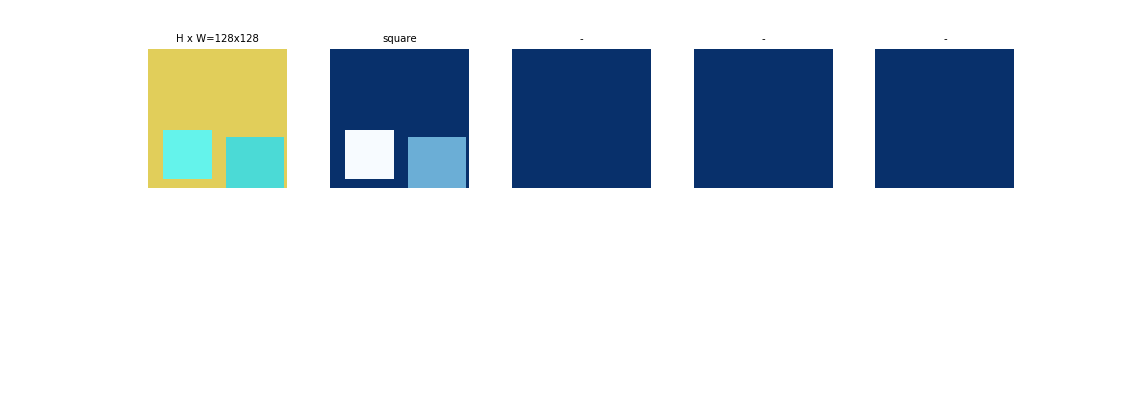

In [354]:
imgmeta_idx= mm.input_names.index('input_image_meta')
img_meta  =  sample_x[imgmeta_idx]
print(img_meta[:,0])
image_id = img_meta[0,0]

image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

### Prepare Ground Truth and Prediction Tensors
Using ground truth inputs to the network, build tensor [ num-classes, num_rois, (roi_information) ]
This Tensor will be used for training purposed on the new head we will be attaching to the existing network 


Using the softmax outputs from the mrcnn head of the network and predicted RoIs , 
build tensor [ num-classes, num_rois, (roi_information) ]

In [349]:
np.set_printoptions(precision=4)
from mrcnn.pc_layer import PCTensor
pc_tensor = PCTensor(model)
pc_tensor.build_predictions(input=sample_x)

gtcls_idx:  4 gtbox_idx : 5
gt_classes.shape : (2, 100) gt_boxes.shape : (2, 100, 4)

 gt_tensor : (idx, class, prob, y1, x1, y2, x2) (2, 4, 100, 8) 

(3, 8)
[[  0.   1.  72.  53. 128. 114.   1.   2.]
 [  0.   1.  73.   0. 128.  53.   2.   0.]
 [  0.   1.  53.  36. 100.  74.   3.   1.]]
(2, 8)
[[  0.   1.  81.  72. 128. 125.   1.   0.]
 [  1.   1.  75.  14. 120.  59.   1.   1.]]
mrcnn_class idx: 6   mrcnn_bbox idx : 7   output_rois idx : 0
 Input Name:  (input_image             ) 	  Input shape: (2, 128, 128, 3)
 Input Name:  (input_image_meta        ) 	  Input shape: (2, 12)
 Input Name:  (input_rpn_match         ) 	  Input shape: (2, 4092, 1)
 Input Name:  (input_rpn_bbox          ) 	  Input shape: (2, 256, 4)
 Input Name:  (input_gt_class_ids      ) 	  Input shape: (2, 100)
 Input Name:  (input_gt_boxes          ) 	  Input shape: (2, 100, 4)
 Input Name:  (input_gt_masks          ) 	  Input shape: (2, 56, 56, 100)
 Output Name: (output_rois             ) 	 Output shape: (2, 32, 4)
 

In [365]:
# pc_tensor.stack_predictions()
# for i in range(len(pc_tensor.pred_stacked)):
#     print(pc_tensor.pred_stacked[i].shape)
#     print(pc_tensor.pred_stacked[i])

# print(pc_tensor.mrcnn_class[0])
# print(pc_tensor.output_rois[0])

# print(pc_tensor.mrcnn_class[0])
# pred_class = np.argmax(pc_tensor.mrcnn_class[0,:,:],axis=1).astype('int16') 
# print(pred_class)

# class_idxs = np.argwhere( pred_class[:] == 3).tolist()
# print(pred_class,'\n', class_idxs)
# print(pc_tensor.output_rois[0,class_idxs])

[1 1 1 2 2 1 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


### Display ground truth bboxes using load_image_gt

Here we are displaying the ground truth bounding boxes as provided by the dataset

[[ 73   0 128  53]
 [ 53  36 100  74]
 [ 72  53 128 114]]


<IPython.core.display.Javascript object>


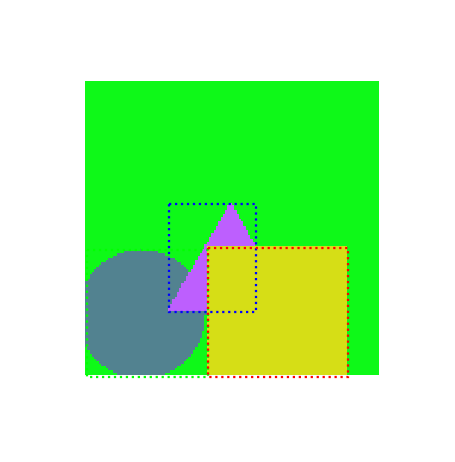

In [352]:
image_id = img_meta[0,0]
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display bboxes from Constructed Ground Truth Tensor

Display the Ground Truth bounding boxes from the tensor we've constructed

[[  0.   1.  72.  53. 128. 114.   1.   2.]
 [  0.   1.  73.   0. 128.  53.   2.   0.]
 [  0.   1.  53.  36. 100.  74.   3.   1.]]


<IPython.core.display.Javascript object>


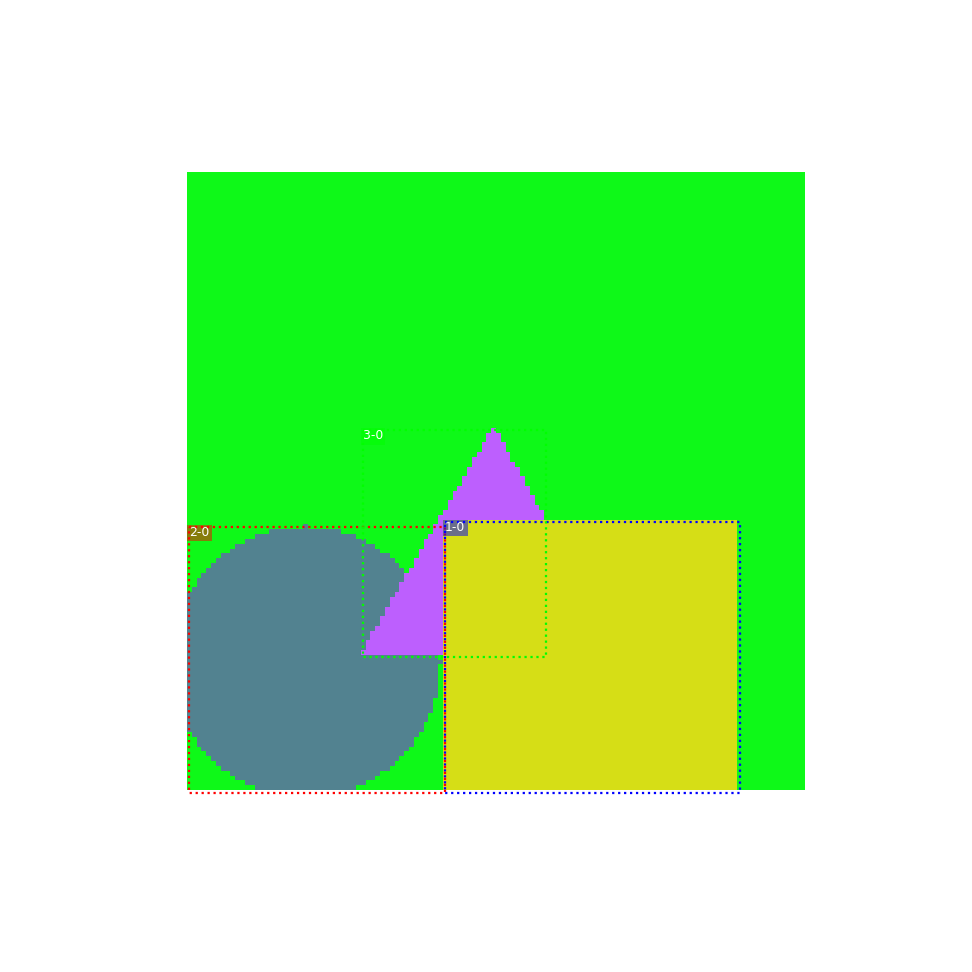

[[  0.   1.  81.  72. 128. 125.   1.   0.]
 [  1.   1.  75.  14. 120.  59.   1.   1.]]


<IPython.core.display.Javascript object>


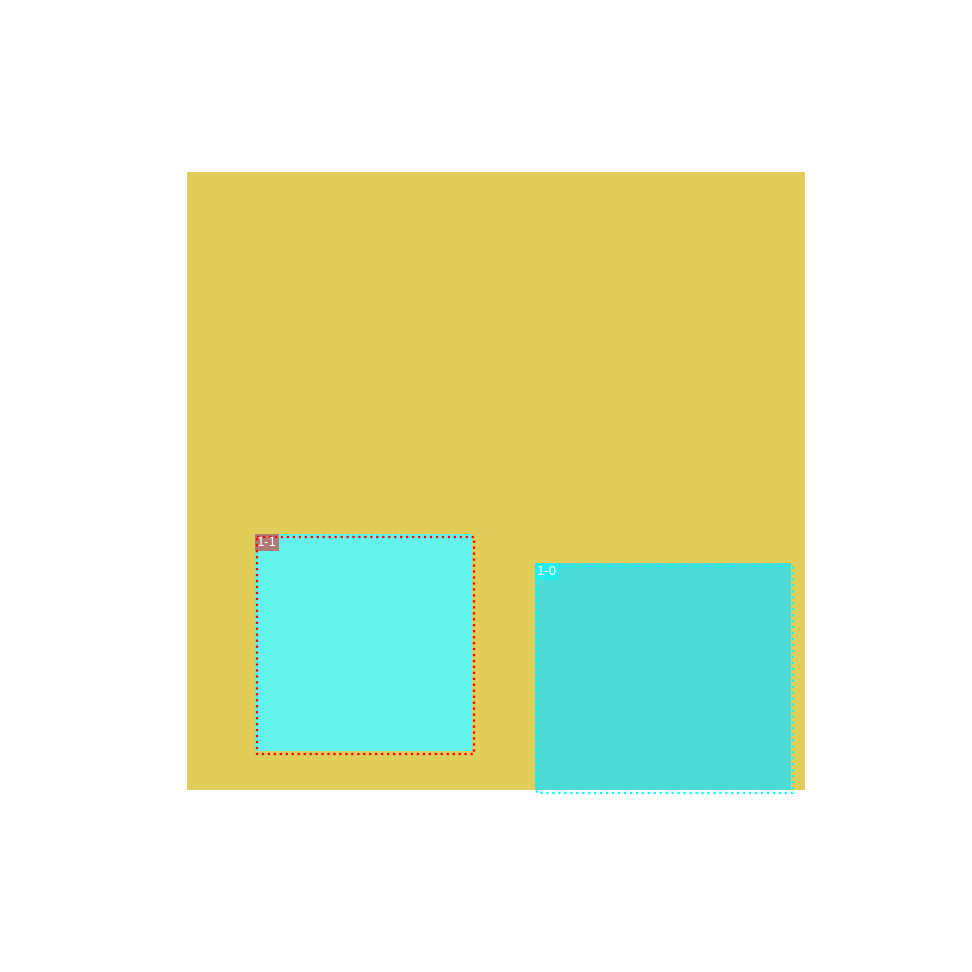

In [357]:
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
for img in range(model.config.BATCH_SIZE):
    image_id = img_meta[img,0]
    image = dataset_train.load_image(image_id)
    caps = [str(x[6])+'-'+str(x[0]) for x in pc_tensor.gt_stacked[img].astype('int16').tolist() ]
    print(pc_tensor.gt_stacked[img])
    visualize.draw_boxes(image, pc_tensor.gt_stacked[img][:,2:6],captions=caps)

## Display RoI proposals generated

Display bounding boxes from tensor of proposals produced by the network 

[[  0.       0.9918  64.4354  43.1161 126.4222 117.7077   1.       2.    ]
 [  1.       0.9894  72.0896  56.154  119.2943 107.0377   1.       5.    ]
 [  2.       0.81    76.4082  66.8985 116.4067 117.6888   1.       0.    ]
 [  3.       0.6415  84.1724  71.4903 127.3773 116.3062   1.       1.    ]
 [  4.       0.5631   0.      46.3445  70.0215 114.6939   1.      26.    ]
 [  0.       0.9334  63.2965   0.     128.      42.4323   2.       8.    ]
 [  1.       0.8069  68.6538   0.     120.8689  51.1103   2.       9.    ]
 [  2.       0.7104  85.1508   0.7412 128.      45.7583   2.       4.    ]
 [  3.       0.6339  47.836    0.     128.      58.1182   2.       6.    ]
 [  4.       0.5711  73.2429   8.4789 113.6453  54.5394   2.       3.    ]]


<IPython.core.display.Javascript object>


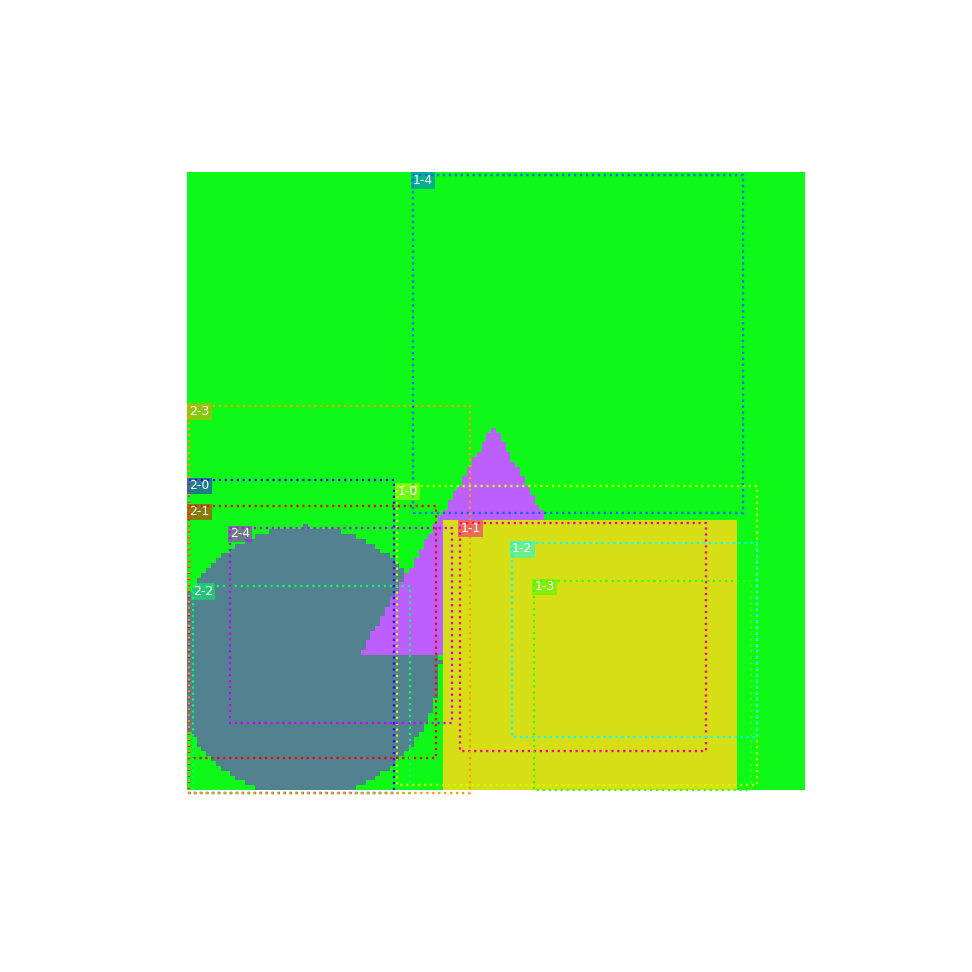

[[  0.       0.9994  75.5871  15.2983 118.6302  60.2478   1.       3.    ]
 [  1.       0.9994  83.7516  74.3068 128.     122.09     1.       7.    ]
 [  2.       0.9992  84.1418  13.9989 125.9387  58.0907   1.       2.    ]
 [  3.       0.9982  76.2303   7.8761 116.992   72.7727   1.       6.    ]
 [  4.       0.9979  71.8708  69.6065 128.     125.9073   1.       1.    ]
 [  5.       0.9971  76.9637  23.5009 118.2355  66.5844   1.       5.    ]
 [  6.       0.9835  75.2819  81.0109 121.4755 128.       1.       8.    ]
 [  7.       0.9635  87.543   86.9366 128.     128.       1.       9.    ]
 [  8.       0.7938  63.8941  76.8134 118.0674 128.       1.       0.    ]
 [  9.       0.7832  79.9313  77.3533 114.5313 115.7945   1.       4.    ]
 [ 10.       0.6894  86.2645  68.9436 121.1486 106.6768   1.      19.    ]]


<IPython.core.display.Javascript object>


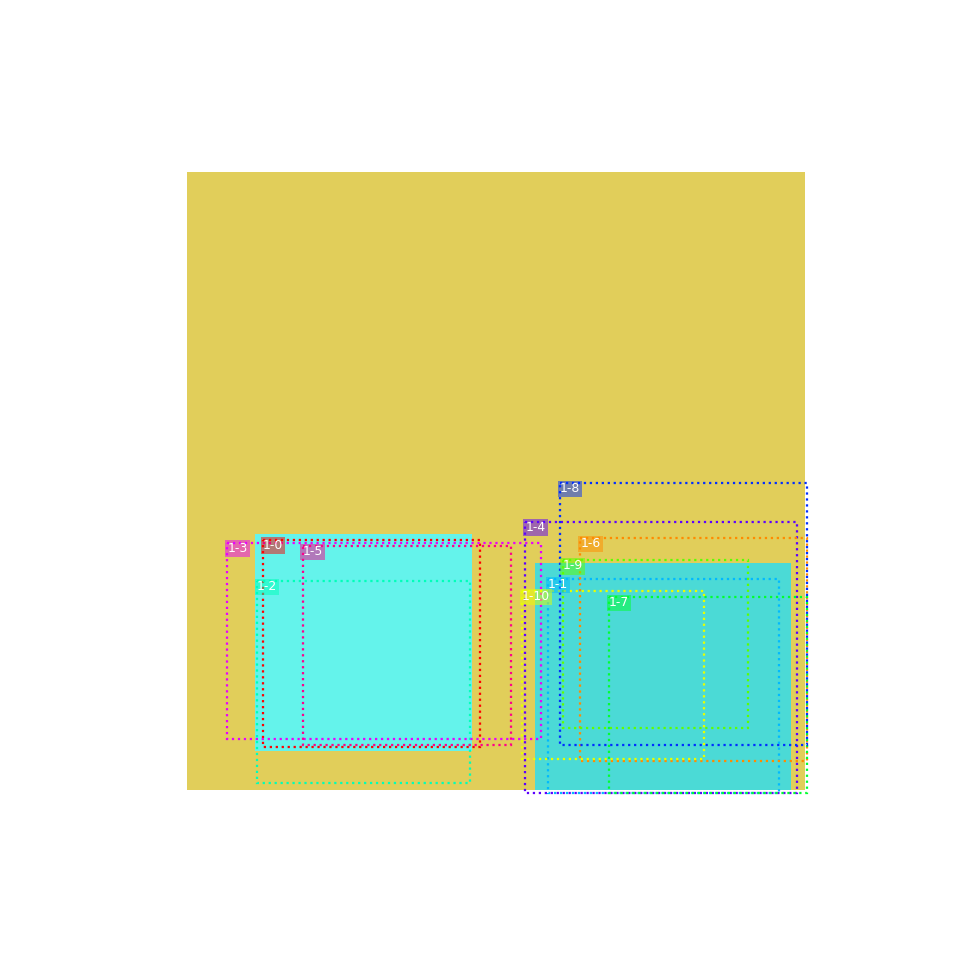

In [358]:
# caps = [str(x[6])+'-'+str(x[0]) for x in pc_tensor.pred_stacked[0].astype('int16').tolist() ]
# print(caps)
# print(pc_tensor.pred_stacked[0])
# visualize.draw_boxes(image, pc_tensor.pred_stacked[0][:,2:6], captions = caps)

for img in range(model.config.BATCH_SIZE):
    image_id = img_meta[img,0]
    image = dataset_train.load_image(image_id)
    caps = [str(x[6])+'-'+str(x[0]) for x in pc_tensor.pred_stacked[img].astype('int16').tolist() ]
    print(pc_tensor.pred_stacked[img])
    visualize.draw_boxes(image, pc_tensor.pred_stacked[img][:,2:6],captions=caps)

For each class:
- determine the center of each bounding box.
- center a 2d gaussian distribution with the mean = center of bounding box and sigma = height/width
- place dist on mesh grid
- normalize
- draw heatmap

In [227]:
# pc_tensor.tensor[0,1,0:pc_tensor.pred_cls_cnt[0,1]]
# pc_tensor.pred_stacked[1]

array([[  0.    ,   0.9992,  11.8211,  68.4475,  71.9192, 122.254 ,   3.    ,   4.    ],
       [  1.    ,   0.9992,  13.4396,  59.9116,  66.121 , 117.3424,   3.    ,   8.    ],
       [  2.    ,   0.9981,  20.4613,  78.5543,  66.3584, 128.    ,   3.    ,   1.    ],
       [  3.    ,   0.9953,  12.6602,  67.0724,  56.5135, 118.0125,   3.    ,   0.    ],
       [  4.    ,   0.9934,   5.009 ,  66.2468,  60.9363, 123.9023,   3.    ,   5.    ],
       [  5.    ,   0.992 ,   3.8332,  62.6112,  75.4204, 128.    ,   3.    ,   2.    ],
       [  6.    ,   0.9512,   0.    ,   0.    ,  66.3818,  49.5092,   3.    ,   9.    ],
       [  7.    ,   0.9464,  28.1413,  67.3613,  64.0073, 108.6938,   3.    ,   6.    ],
       [  8.    ,   0.8931,  13.3808,  12.0156,  60.4415,  67.7482,   3.    ,   3.    ],
       [  9.    ,   0.571 ,  21.2524,  73.9702,  98.5206, 128.    ,   3.    ,   7.    ]])

In [369]:
from mrcnn.pc_layer import build_gaussian
Zout = build_gaussian(pc_tensor)
Zout.shape

class id:  0 class count:  22
** bbox is :  [  0.       1.      83.7907  96.9113 107.1106 128.       0.      20.    ]
    center is (112.455639,95.450653)  width is 31.088722 height is 23.319839 
** bbox is :  [  1.       1.       0.      34.3444  32.3359 114.1886   0.      16.    ]
    center is (74.266502,16.167927)  width is 79.844208 height is 32.335854 
** bbox is :  [ 2.  1.  0.  0.  0.  0.  0. 31.]
    center is (0.000000,0.000000)  width is 0.000000 height is 0.000000 
** bbox is :  [ 3.  1.  0.  0.  0.  0.  0. 30.]
    center is (0.000000,0.000000)  width is 0.000000 height is 0.000000 
** bbox is :  [ 4.      1.     17.0039 42.3652 56.8971 84.46    0.     17.    ]
    center is (63.412601,36.950504)  width is 42.094749 height is 39.893204 
** bbox is :  [  5.       0.9999   5.2934  88.2242  42.2086 128.       0.      12.    ]
    center is (108.112114,23.750993)  width is 39.775772 height is 36.915190 
** bbox is :  [ 6.      0.9995  7.5169 25.2673 58.8811 87.5035  0.     24.

(2, 4, 128, 128)

In [343]:
from mrcnn.pc_layer import bbox_gaussian
num_classes = model.config.NUM_CLASSES
Zout2 = np.zeros((num_classes, 128,128))
for cls in range(num_classes):
    print('class: ',i, 'class count', pc_tensor.pred_cls_cnt[0,cls])
    if pc_tensor.pred_cls_cnt[0,cls] > 0:
        for box in range(pc_tensor.pred_cls_cnt[0,cls]):
            print(' box nimber ',box)
            print(pc_tensor.tensor[0,cls,box])
            Zout2[cls] += bbox_gaussian(pc_tensor.tensor[0,cls,box], Zout2[cls])
print(Zout2.shape)
# plot_gaussian(Zout)


class:  1 class count 22
 box nimber  0
[ 0.      1.      0.      0.     15.1288 19.634   0.     15.    ]
center is (9.816996,7.564406) width: 19.633991  height: 15.128813 
 box nimber  1
[ 1.  1.  0.  0.  0.  0.  0. 31.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box nimber  2
[ 2.  1.  0.  0.  0.  0.  0. 30.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box nimber  3
[  3.       0.9999 115.7084   0.     128.      12.7326   0.      19.    ]
center is (6.366317,121.854202) width: 12.732635  height: 12.291595 
 box nimber  4
[  4.       0.9999  17.5319  93.0845  46.1906 128.       0.      13.    ]
center is (110.542236,31.861254) width: 34.915527  height: 28.658611 
 box nimber  5
[ 5.      0.9999  3.1955 23.3588 40.0712 65.5129  0.     12.    ]
center is (44.435831,21.633311) width: 42.154095  height: 36.875696 
 box nimber  6
[  6.       0.9999  60.1223  92.5839  97.593  128.       0.      14.    ]
center is (110.291962,78.857613) width: 35.

<IPython.core.display.Javascript object>


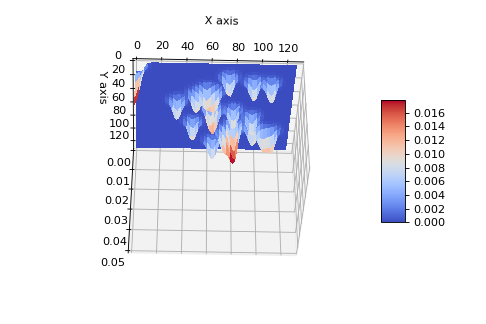

<IPython.core.display.Javascript object>


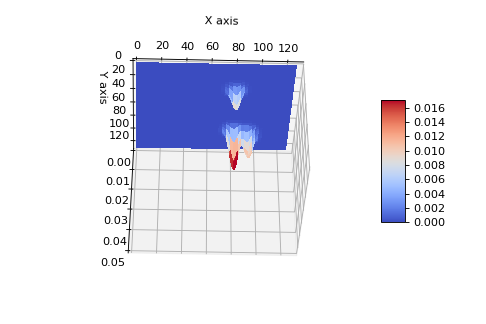

<IPython.core.display.Javascript object>


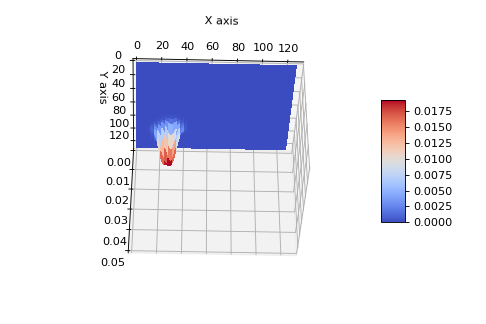

<IPython.core.display.Javascript object>


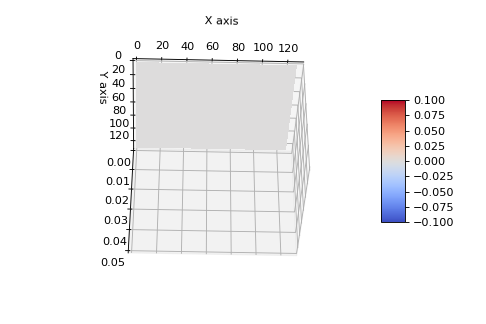

In [370]:
%matplotlib notebook
from mrcnn.visualize import plot_gaussian
for i in range(4):
    plot_gaussian(Zout[0,i])


<IPython.core.display.Javascript object>


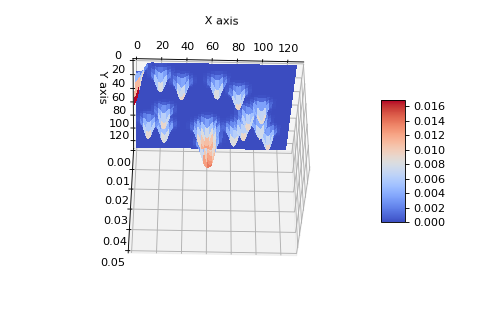

<IPython.core.display.Javascript object>


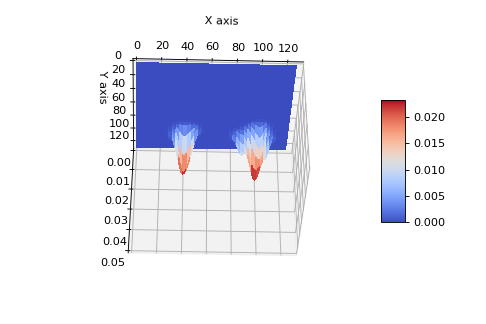

<IPython.core.display.Javascript object>


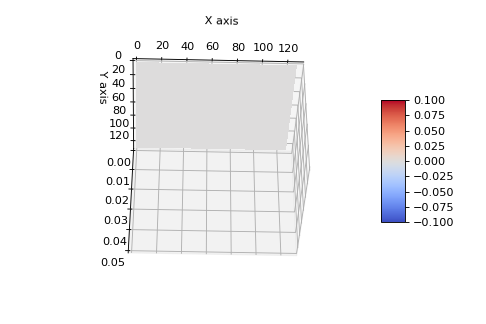

<IPython.core.display.Javascript object>


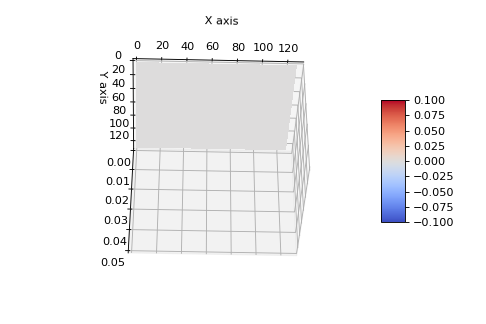

In [371]:
%matplotlib notebook
from mrcnn.visualize import plot_gaussian
for i in range(4):
    plot_gaussian(Zout[1,i])

In [341]:
# %matplotlib notebook
# from mrcnn.visualize import plot_gaussian
# for i in range(4):
#     plot_gaussian(Zout2[i])
# plot_gaussian(Zout[3])

#### Compare Gaussians from build_gaussian() and bbox_gaussian()

In [372]:
# Zout2.shape
# plot_gaussian(Zout[0,0])
# plot_gaussian(Zout2[0])
# plot_gaussian(Zout[0,1])
# plot_gaussian(Zout2[1])

### Display Ground Truth Gaussians

In [373]:
from mrcnn.pc_layer import bbox_gaussian
num_classes = model.config.NUM_CLASSES
img_h, img_w = model.config.IMAGE_SHAPE[:2]
Zout3 = np.zeros((num_classes, img_w, img_h))
print(pc_tensor.gt_cls_cnt)

for cls in range(num_classes):
    print('class: ',cls, 'class count', pc_tensor.gt_cls_cnt[0,cls])
    if pc_tensor.gt_cls_cnt[0,cls] > 0:
        for box in range(pc_tensor.gt_cls_cnt[0,cls]):
            print(' box ',box, '    ',pc_tensor.gt_tensor[0,cls,box])
            Zout3[cls] += bbox_gaussian(pc_tensor.gt_tensor[0,cls,box], Zout3[cls])
print(Zout3.shape)

[[97  1  1  1]
 [98  2  0  0]]
class:  0 class count 97
 box  0      [0. 1. 0. 0. 0. 0. 0. 3.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box  1      [1. 1. 0. 0. 0. 0. 0. 4.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box  2      [2. 1. 0. 0. 0. 0. 0. 5.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box  3      [3. 1. 0. 0. 0. 0. 0. 6.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box  4      [4. 1. 0. 0. 0. 0. 0. 7.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box  5      [5. 1. 0. 0. 0. 0. 0. 8.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box  6      [6. 1. 0. 0. 0. 0. 0. 9.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box  7      [ 7.  1.  0.  0.  0.  0.  0. 10.]
center is (0.000000,0.000000) width: 0.000000  height: 0.000000 
 box  8      [ 8.  1.  0.  0.  0.  0.  0. 11.]
center is (0.000000,0.000000) width: 0.000000  height: 0.

<IPython.core.display.Javascript object>


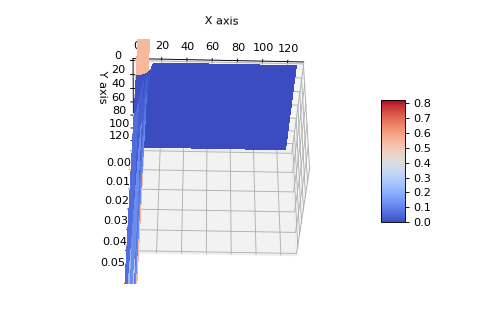

<IPython.core.display.Javascript object>


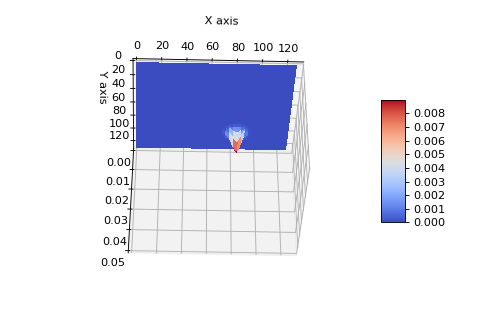

<IPython.core.display.Javascript object>


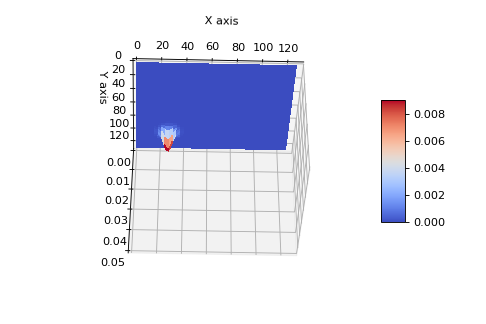

<IPython.core.display.Javascript object>


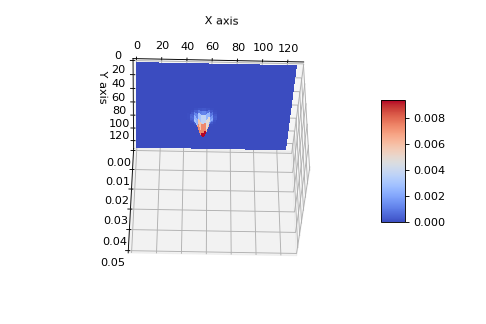

[[  0.   1.  72.  53. 128. 114.   1.   2.]
 [  0.   1.  73.   0. 128.  53.   2.   0.]
 [  0.   1.  53.  36. 100.  74.   3.   1.]]


<IPython.core.display.Javascript object>


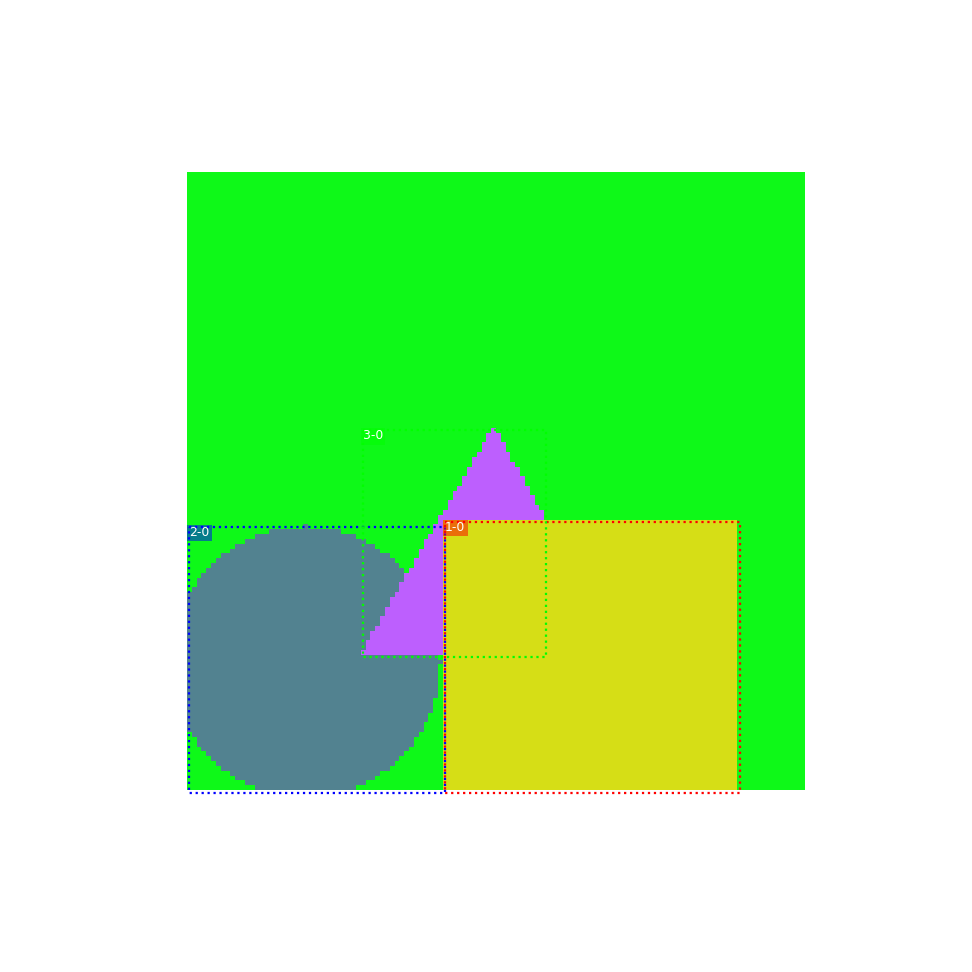

In [376]:
# pc_tensor.gt_cls_cnt.shape
# Zout3 = np.zeros((num_classes, 128,128))
# for i in range(1,num_classes):
#     print('class: ',i)
#     for j in range(pc_tensor.gt_cls_cnt[i]):
#         Zout[i] += bbox_gaussian(pc_tensor.gt_tensor[i,j], Zout[i])
# print(Zout.shape)

for i in range(4):
    plot_gaussian(Zout3[i])

image_id = img_meta[0,0]
image = dataset_train.load_image(image_id)

caps = [str(x[6])+'-'+str(x[0]) for x in pc_tensor.gt_stacked[0].astype('int16').tolist() ]
print(pc_tensor.gt_stacked[0][:,:])
visualize.draw_boxes(image, pc_tensor.gt_stacked[0][:,2:6],captions=caps)

## Fine Tuning
Fine tune all layers

In [377]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=22,
            layers="all")

Starting at epoch 224 of 226 epochs. LR=0.0001

Steps per epochs 7 
Checkpoint Path: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_{epoch:04d}.h5

Selecting layers to train
Layer    Layer Name               Layer Type
  2  conv1                  (Conv2D)
  3  bn_conv1               (BatchNorm)
  6  res2a_branch2a         (Conv2D)
  7  bn2a_branch2a          (BatchNorm)
  9  res2a_branch2b         (Conv2D)
 10  bn2a_branch2b          (BatchNorm)
 12  res2a_branch2c         (Conv2D)
 13  res2a_branch1          (Conv2D)
 14  bn2a_branch2c          (BatchNorm)
 15  bn2a_branch1           (BatchNorm)
 18  res2b_branch2a         (Conv2D)
 19  bn2b_branch2a          (BatchNorm)
 21  res2b_branch2b         (Conv2D)
 22  bn2b_branch2b          (BatchNorm)
 24  res2b_branch2c         (Conv2D)
 25  bn2b_branch2c          (BatchNorm)
 28  res2c_branch2a         (Conv2D)
 29  bn2c_branch2a          (BatchNorm)
 31  res2c_branch2b         (Conv2D)
 32  bn2c_branch2b          (BatchNorm)


D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 225/226
6/7 [========================>.....] - ETA: 1s - loss: 0.7191 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2670 - mrcnn_class_loss: 0.1313 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.2249
Epoch 00225: loss improved from inf to 0.75847, saving model to E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0225.h5
7/7 [==============================] - 13s 2s/step - loss: 0.7585 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.2381 - val_loss: 0.8546 - val_rpn_class_loss: 0.0133 - val_rpn_bbox_loss: 0.3919 - val_mrcnn_class_loss: 0.1498 - val_mrcnn_bbox_loss: 0.0866 - val_mrcnn_mask_loss: 0.2129
Epoch 226/226
6/7 [========================>.....] - ETA: 0s - loss: 0.6039 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2981 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1580
Epoch 00226: loss improved from 0.75847 to 0.54029, saving model to E:\Models\mrcnn_logs\shapes201803

## Save 

In [14]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
# lay = mm.layers[229]
# print(lay.__class__, lay.__class__.__name__)
# pp.pprint(dir(lay))
# pp.pprint(lay.input_spec.__dict__)
# pp.pprint(lay.output.__dict__)
# print(type(lay.output))
# print(keras.backend.is_keras_tensor(lay))
# print(K.eval(lay.output))

In [217]:
# print(pred_index.shape, pred_class.shape, pred_prob.shape)
# b_cpb = np.column_stack((pred_index, pred_class, pred_prob, rois)) # , b_probs)) #.transpose()
# print(' b_cpb shape: ',b_cpb.shape,'\n',b_cpb)

# print(b_cpb[:,3:] bbox_delta)

# nonbg_idx = np.argwhere(b_cpb[:,1]) 

# print(type(nonbg_idx))
# b_cpb_nonbg = b_cpb[nonbg_idx,:].squeeze()

# print(b_cpb_nonbg)
# order = b_cpb_nonbg[:,2].argsort()



# print('\n srtd_cpb : (idx, class, prob, y1, x1, y2, x2)',srtd_cpb.shape, '\n')
# print(srtd_cpb)

# # srtd_cpb_2 has (idx, cls_idx, prob, cx ,cy, width, height) instead of (idx, cls_idx, prob, y1, x1, y2, x2)

# width  = srtd_cpb[:,6]-srtd_cpb[:,4]
# height = srtd_cpb[:,5]-srtd_cpb[:,3]
# cx = srtd_cpb[:,4] + ( width  / 2.0)
# cy = srtd_cpb[:,3] + ( height / 2.0)
# print('\n srtd_cpb_2 : (idx, class, prob, cx ,cy, width, height) instead of (y1, x1, y2, x2)')
# srtd_cpb_2 = np.column_stack((srtd_cpb[:, 0:3], cx,cy, width, height ))

# print('\n',srtd_cpb_2)